# `Setup`

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch import nn
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


### `Config`

In [5]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `Data Import`

In [6]:
# IMG Transformations
transforms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.Resize((224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImageTensor(),
    v2.ToDtype(torch.float32, scale=True)])


transforms_v2 = v2.Compose([
    T.Grayscale(num_output_channels=1),
    v2.RandomResizedCrop(size=(224, 224), antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485], std=[0.229])
    ])


# val_transforms = T.Compose([
#     T.ToPILImage(),
#     T.Resize((224, 224), antialias=True),
#     v2.ToImageTensor(),
#     v2.ToDtype(torch.float32, scale=True)])


# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))
# target_transform = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(int(y.replace('c', ''))), value=1))

In [7]:
# Creating the dataset
train_data = StateFarmDataset(config, transform=transforms_v2, split='train', target_transform=target_transform)
print(f'Lenght of train data: {len(train_data)}')
val_data = StateFarmDataset(config, split='test', transform=transforms_v2, target_transform=target_transform)
print(f'Lenght of val data: {len(val_data)}')

Lenght of train data: 18070
Lenght of val data: 4354


In [8]:
train_data.img_labels = train_data.img_labels
train_data.metadata.target.value_counts(True)

safe driving                    0.108135
texting - left                  0.104815
talking on the phone - right    0.103985
talking on the phone - left     0.103486
drinking                        0.102656
operating the radio             0.102380
texting - right                 0.101051
talking to passenger            0.097399
reaching behind                 0.088268
hair and makeup                 0.087825
Name: target, dtype: float64

In [9]:
val_data.img_labels = val_data.img_labels
val_data.img_labels.classname.value_counts(True)

c0    0.122876
c6    0.107947
c5    0.106109
c4    0.104731
c3    0.103813
c1    0.101286
c2    0.100597
c7    0.093477
c9    0.084750
c8    0.074414
Name: classname, dtype: float64

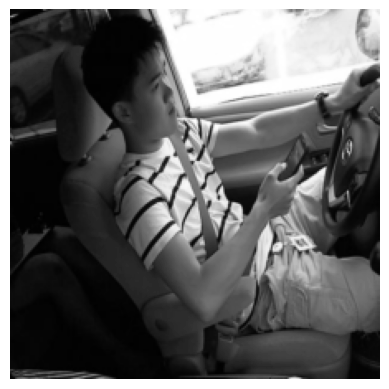

In [10]:
img, _ = train_data[100]
plt.imshow(img.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

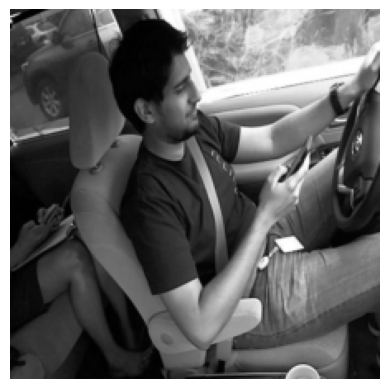

In [11]:
img, _ = val_data[100]
plt.imshow(img.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

## `VGG11`
Building VGG-11 Architecture. Architecture can be found [here](https://jaketae.github.io/study/pytorch-vgg/)

In [45]:
class VGG11(torch.nn.Module):
    def __init__(self, filters = 64, num_classes = 10, kernel_size = (3,3), stride = 1, in_channels = 3, pool_kernel_size = (2,2)):
        """VGG 11 Model"""
        super(VGG11, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=filters,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=filters,
                      out_channels=filters*2,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2))
        
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=filters*2,
                      out_channels=filters*4,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters*4,
                      out_channels=filters*4,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=filters*4,
                      out_channels=filters*8,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters*8,
                      out_channels=filters*8,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2))
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=filters*8,
                      out_channels=filters*8,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters*8,
                      out_channels=filters*8,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2))
        
        
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=num_classes))


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = self.linear(x)
        return out

In [46]:
# Instantiating the model
model = VGG11(in_channels=1)

model

VGG11(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Ma

In [47]:
batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [48]:
# Model summary
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
VGG11                                    [32, 10]                  --
├─Sequential: 1-1                        [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [32, 64, 224, 224]        128
│    └─ReLU: 2-3                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 64, 112, 112]        --
├─Sequential: 1-2                        [32, 128, 56, 56]         --
│    └─Conv2d: 2-5                       [32, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-6                  [32, 128, 112, 112]       256
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-8                    [32, 128, 56, 56]         --
├─Sequential: 1-3                        [32, 256, 28, 28]         --
│    └─Conv2d: 2-9                       [32, 256, 56, 56]         295,168
│  

#### `Training Methods`

In [49]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [55]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch"""
    # Set model to train mode
    model.train()

    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        print(batch)

        # Move data to device
        X, y = X.to(device), y.to(device)

        # Forward pass
        out = model(X)
        loss = loss_fn(out, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (out.argmax(1) == y).type(torch.float).mean().item()

    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [56]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Set model to eval mode
    model.eval()

    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculatio
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            # Move data to device
            X, y = X.to(device), y.to(device)

            # Forward pass and update validation loss
            out = model(X)
            loss = loss_fn(out, y)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (out.argmax(1) == y).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [57]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Loop through epochs
    for epoch in range(epochs):
        print(f'Epoch {epoch+1} started...')
        # Training
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Validation
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)

        # lr Scheduler step
        scheduler.step(val_loss)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print info
        print(f"Epoch {epoch+1} of {epochs} - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: visualize_training(history, epochs)

In [58]:
# Set random seeds
torch.manual_seed(42)


# Recreate an instance of TinyVGG
model = VGG11(in_channels=1).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.01, 
                             weight_decay=1e-5,
                             eps=1e-06)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min',
                                                       factor=.1,
                                                       patience=5,
                                                       min_lr=1e-7,
                                                       verbose=True)

# Train model_0
model_0_results = train(model=model,
                        train_dataloader=train_dataloader,
                        validation_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=epochs,
                        device=device,
                        scheduler=scheduler)

Epoch 1 started...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


RuntimeError: MPS backend out of memory (MPS allocated: 16.43 GB, other allocations: 1.67 GB, max allowed: 18.13 GB). Tried to allocate 49.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [210]:
import datetime as dt

try:
    torch.save(model.state_dict(), config['outputs']['path'] + '/TinyVGG/' + f'{dt.datetime.now().strftime("%Y%m%d")}_tiny_vgg_w_augmentation.pth')
except:
    os.mkdir(config['outputs']['path'] + '/TinyVGG/')
    torch.save(model.state_dict(), config['outputs']['path'] + '/TinyVGG/' + f'{dt.datetime.now().strftime("%Y%m%d")}_tiny_vgg_w_augmentation.pth')
print('Model saved')

Model saved


In [211]:
# testing_model

# Getting random batch from validation data
x, y = next(iter(test_dataloader))

In [212]:
out = model(x.to(device))

In [214]:
out.argmax(1)

tensor([6, 1, 2, 9, 0, 1, 0, 8, 2, 0, 6, 8, 0, 1, 3, 8, 4, 0, 0, 8, 3, 3, 9, 7,
        1, 0, 7, 7, 8, 1, 7, 2], device='mps:0')

In [227]:
(out.argmax(1) == y.to(device)).type(torch.float) .mean().item()

0.4375